# Observational Study in Labor Risk Market

The main objective of this project is to assess whether the sanction of the law 27.348 in
Argentina has affected the judiciality in the labor risk market and, if so, what was the magnitude
of the impact. To perform this evaluation, an observational study will be conducted on
longitudinal data, using propensity score matching and difference-in-difference techniques.

## Library Import

In order to run pymatch it is necessary to use the 0.23.4 version of pandas

In [1]:
#pip install pandas==0.23.4

In [2]:
#### Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymatch.Matcher import Matcher
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', '{:.3f}'.format)

## Preprocessing

In [3]:
#### Data load
file = 'C:/GoogleDrive/MiM+Analytics/3 - Business Aplications of Data Analytics/TP/siniestrodata_clean.csv'
df0 = pd.read_csv(file, encoding = 'latin-1', sep = '\t', decimal = '.')

In [4]:
#### Feature Engineering
df0['tamano_empresa'] = np.select([df0['capitas_12m'].between(1, 9.99, inclusive=True),
                                  df0['capitas_12m'].between(10, 25.99, inclusive=True),
                                  df0['capitas_12m'].between(26, 50.99, inclusive=True),
                                  df0['capitas_12m'].between(51, 100.99, inclusive=True),
                                  df0['capitas_12m'].between(101, 250, inclusive=True),
                                  df0['capitas_12m'].between(250.01, 500.99, inclusive=True),
                                  df0['capitas_12m'].between(500.99, 999999999999, inclusive=True),
                                  ],
                                 ['1_10', '10_25', '26_50', '51_100', '101_250', '251-500', 'mas500'],
                                 default='1_10'
                                 )

df0['antiguedad'] = (pd.to_datetime(df0['F_ACC']) - pd.to_datetime(df0['F_INGRESO'])).dt.days
df0['frec_siniestral_cto'] = np.where(df0['capitas_12m'] == 0, 0, df0['q_siniestros'] / df0['capitas_12m'])
df0['share_juicios_cto']   = np.where(df0['q_siniestros'] == 0, 0, df0['q_juicios'] / df0['q_siniestros'])
df0['pct_sin_graves_cto']  = np.where(df0['q_siniestros'] == 0, 0, df0['q_siniestros_graves'] / df0['q_siniestros'])

# Time variable representing the trend
df0['var_temporal'] = ((pd.to_datetime(df0['F_ACC']) - pd.to_datetime('01/01/1970')).dt.days)/30

# Target variable (whether the claim ended in a trial or not)
df0['target'] = np.where(df0['JUI'] == True, 1, 0)

### Treatment / Control groups

The dataset has approximately 10.000 insurance claims, ranging from 2015-08 to 2019-04. Since
the first province that implemented the new law was Buenos Aires, all claims coming from this
province will be considered as **treated**. The rest of the claims (coming from other provinces) will
be **controls**. The time frame has been selected taking into consideration the implementation
date of the law in Buenos Aires (2017-03) - there are 20 months of data before and 20 months
after the application of the treatment.

The **target variable** is whether each of these claims ended in a trial or not. It is expected that the
treated group claims will have a smaller trial frequency than the control group.

In [5]:
#### Distinction of treatment and control groups
# Province = 1 corresponds to Buenos Aires
df0['T_C'] = np.where(df0['PCIA_TDOR'] == 1, 1, 0)

In [6]:
#### Final dataset for observational study
cols = ['mes_renovacion', 'F_ACC', 'MESACC', 'SEXO', 'EDAD', 'IBM', 'antiguedad', 'PCIA_TDOR', 'sector', 'ciiu3', 'ciiu6', 
        'tamano_empresa', 'capitas_12m', 'masa_salarial_12m', 'frec_siniestral_cto', 'share_juicios_cto', 
        'pct_sin_graves_cto', 'pct_hombres', 'var_temporal', 'T_C', 'target']

# We take 20 months before and after 201703 (application of the new law)
df = df0[pd.to_numeric(df0['MESACC']).between(201508, 201904,inclusive = True)][cols].dropna().copy()

df.rename(columns = {'F_ACC': 'fecha_acc',
                     'MESACC': 'mes_acc',
                     'SEXO': 'sexo',
                     'EDAD': 'edad',
                     'IBM': 'ibm'}, inplace = True)

In [7]:
#### Generation of treatment and control sets
treatment = df[df['T_C'] == 1]
control   = df[df['T_C'] == 0]

print('# Treatment cases: {} ({} %)'.format(len(treatment), np.round(len(treatment) / len(df) * 100,2)))
print('# Control cases: {} ({} %)'.format(len(control), np.round(len(control) / len(df) * 100,2)))

# Treatment cases: 724 (7.16 %)
# Control cases: 9383 (92.84 %)


## Matching

There are two main tasks that will be performed in order to assess the impact:
1. Matching over treatment and control groups
2. Difference-in-Difference

### t-test for mean

Out of the 10.107 claims, 724 are treated and 9.383 are controls. To begin with the analysis,
t-tests will be performed on the eight covariates to determine if there is overt biases.

In [8]:
print('t-test for edad: ', stats.ttest_ind(treatment['edad'], control['edad']))
print('t-test for ibm: ', stats.ttest_ind(treatment['ibm'], control['ibm']))
print('t-test for antiguedad: ', stats.ttest_ind(treatment['antiguedad'], control['antiguedad']))
print('t-test for frec_siniestral_cto: ', stats.ttest_ind(treatment['frec_siniestral_cto'], control['frec_siniestral_cto']))
print('t-test for share_juicios_cto: ', stats.ttest_ind(treatment['share_juicios_cto'], control['share_juicios_cto']))
print('t-test for pct_hombres: ', stats.ttest_ind(treatment['pct_hombres'], control['pct_hombres']))
print('t-test for capitas_12m: ', stats.ttest_ind(treatment['capitas_12m'], control['capitas_12m']))
print('t-test for var_temporal: ', stats.ttest_ind(treatment['var_temporal'], control['var_temporal']))

t-test for edad:  Ttest_indResult(statistic=-2.1110117155593264, pvalue=0.034795800192020505)
t-test for ibm:  Ttest_indResult(statistic=5.077819638246347, pvalue=3.885991756042445e-07)
t-test for antiguedad:  Ttest_indResult(statistic=-3.217024801497955, pvalue=0.0012993558152853127)
t-test for frec_siniestral_cto:  Ttest_indResult(statistic=-4.764176806356428, pvalue=1.922669343328882e-06)
t-test for share_juicios_cto:  Ttest_indResult(statistic=9.952378370918582, pvalue=3.149004992680092e-23)
t-test for pct_hombres:  Ttest_indResult(statistic=-11.925796488337907, pvalue=1.4358612477087655e-32)
t-test for capitas_12m:  Ttest_indResult(statistic=11.171384420342712, pvalue=8.300760076216625e-29)
t-test for var_temporal:  Ttest_indResult(statistic=-1.172771271782613, pvalue=0.2409151866026645)


The only covariate that have the same distribution for treatment and control groups is "var_temporal". Therefore, it is necessary to try a matching approach in order to improve the similarity of the other covariates.

### Matcher

The detected overt biases can be controlled by adjustments, such as matching or stratification. Therefore, we will create matched sets with the same value of the covariates and then compared treated and control subjects within these strata. A propensity score model was trained to perform the matching task:

In [9]:
exclude_cols = ['mes_renovacion', 'fecha_acc', 'mes_acc', 'PCIA_TDOR', 'ciiu3', 'ciiu6', 'T_C', 'target',
                'masa_salarial_12m', 'pct_sin_graves_cto']

m = Matcher(treatment, control, yvar = "T_C", exclude = exclude_cols)

Formula:
T_C ~ sexo+edad+ibm+antiguedad+sector+tamano_empresa+capitas_12m+frec_siniestral_cto+share_juicios_cto+pct_hombres+var_temporal
n majority: 9383
n minority: 724


There is a significant **class imbalance** in the data -- the majority group having many more records than the minority group. We account for this by setting "balance = True" when calling Matcher.fit_scores() below. This tells Matcher to sample from the majority group when fitting the logistic regression models so that the groups are of equal size.

In [10]:
# for reproducibility
np.random.seed(1984)

m.fit_scores(balance = True, nmodels = 200)

Fitting Models on Balanced Samples: 200\200
Average Accuracy: 68.26%


The average accuracy of the 200 models is 68.26%, suggesting that there's separability within the data and justifiying the need for the matching procedure.

### Predict Scores

In [11]:
m.predict_scores()

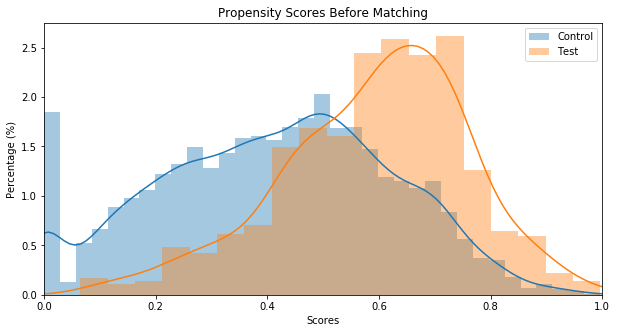

In [12]:
m.plot_scores()

The plot above demonstrates the separability present in the data. Test profiles have a much higher propensity.

### Tune Threshold

By default matches are found from the majority group for the minority group. If a record in the minority group has no suitable matches, it is dropped from the final matched dataset. We need to ensure our threshold is small enough such that we get close matches and retain most (or all) of our data in the minority group.

Below we tune the threshold using method="random". This matches a random profile that is within the threshold as there could be many. This is much faster than the alternative method "min", which finds the closest match for every minority record.

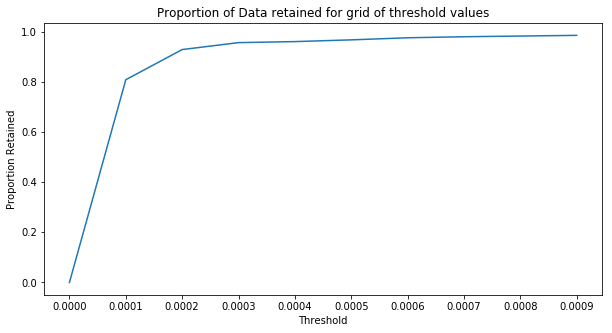

In [13]:
m.tune_threshold(method='random')

It looks like a threshold of 0.0005 retains almost 100% of the data. Let's proceed with matching using this threshold.

### Match Data

Below we match one record from the majority group to each record in the minority group. This is done with replacement, meaning a single majority record can be matched to multiple minority records.

In [14]:
m.match(method="min", nmatches=1, threshold=0.0005)

In [15]:
m.record_frequency()

,freq,n_records
0,1,1283
1,2,60
2,3,11
3,4,3


It looks like the bulk of our matched-majority-group records occur only once, 46 occur twice, ... etc.

In [16]:
#### We assign the propensity score to each record in the table
m.assign_weight_vector()

### Assess Matches

We must now determine if data is "balanced" across the covariates. 

#### Categorical covariates

For categorical variables, we look at plots comparing the proportional differences between test and control before and after matching. We want the after bars (oranges) to be small after matching.

Results (pvalue) of a Chi-Square Test for Independence before and after matching are also presented. After matching we want this pvalue to be > 0.05, resulting in our failure to reject the null hypothesis that the frequency of the enumerated term values are independent of our test and control groups.

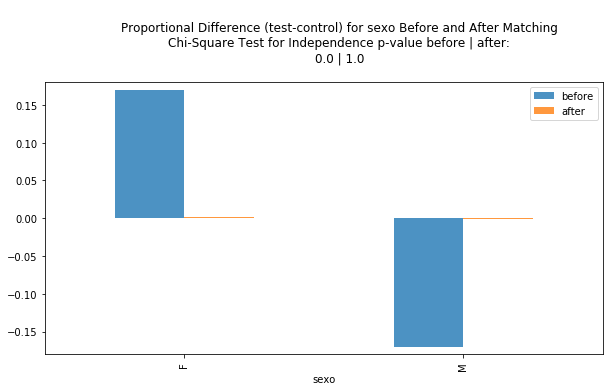

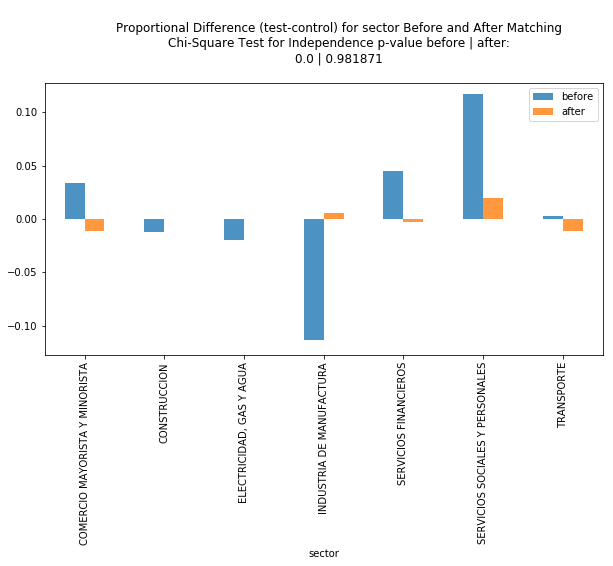

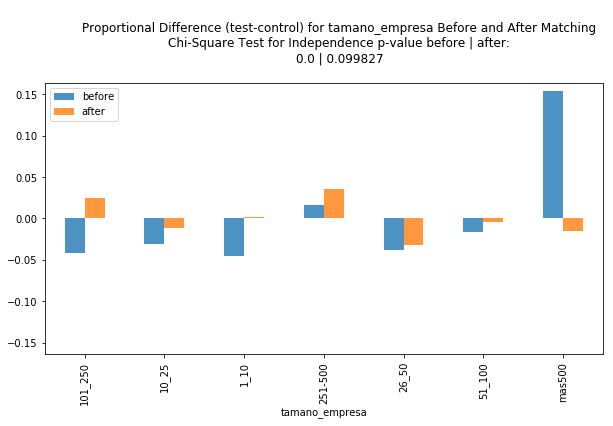

In [17]:
categorical_results = m.compare_categorical(return_table=True)

In [18]:
categorical_results

,var,before,after
0,sexo,0.000,1.000
1,sector,0.000,0.982
2,tamano_empresa,0.000,0.100


Looking at the plots and test results, it can be seen that all categorical features have been balanced. The p-values from the Chi-Square tests are all > 0.05 and we can verify by observing the small proportional differences in the plots.

#### Continuous covariates

For continuous variables we look at Empirical Cumulative Distribution Functions (ECDF) for our test and control groups before and after matching.

- **ECDF for test vs ECDF for control** before matching (left), ECDF for test vs ECDF for control after matching (right) are presented. We want the two lines to be very close to each other (or indistiguishable) after matching.

Some tests + metrics are included in the chart titles.
Tests performed:

- **Kolmogorov-Smirnov Goodness of fit Test (KS-test):** this test statistic is calculated on 1000 permuted samples of the data, generating an imperical p-value. 
- **Chi-Square Distance:** Similarly this distance metric is calculated on 1000 permuted samples.

Other included Stats:

- **Standarized mean and median differences:** how many standard deviations away are the mean/median between our groups before and after matching i.e. abs(mean(control) - mean(test)) / std(control.union(test))

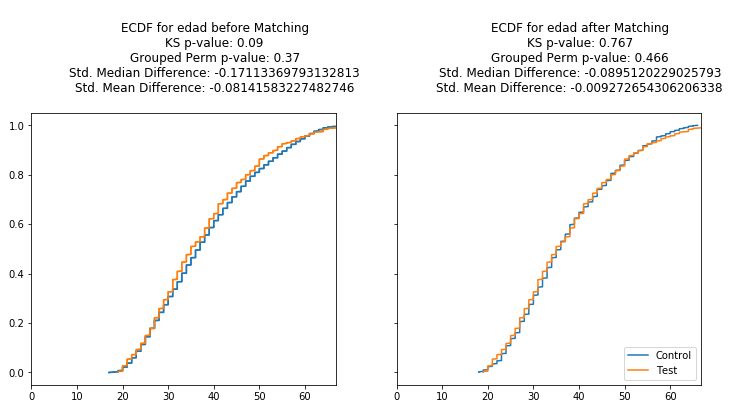

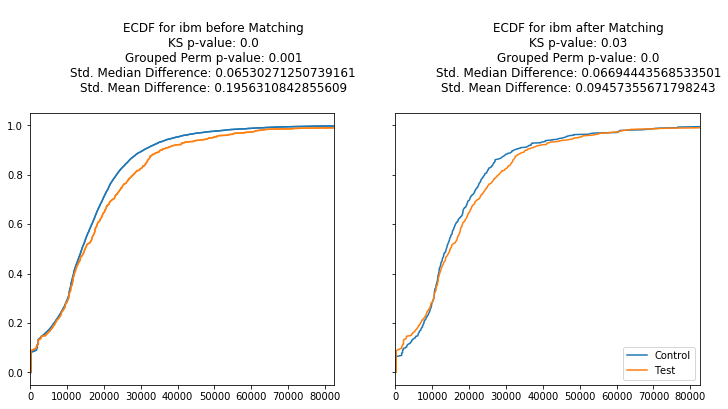

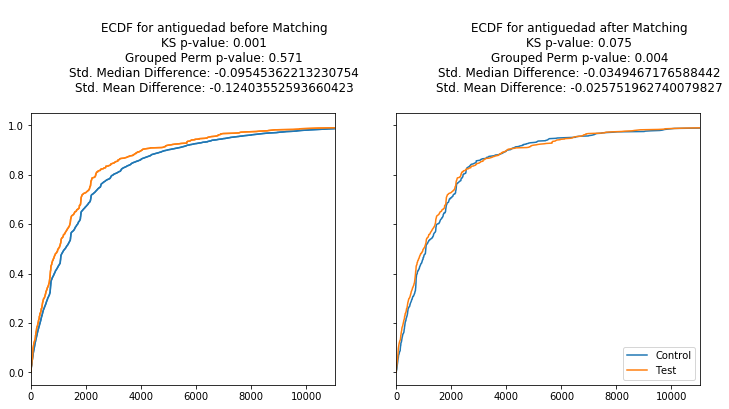

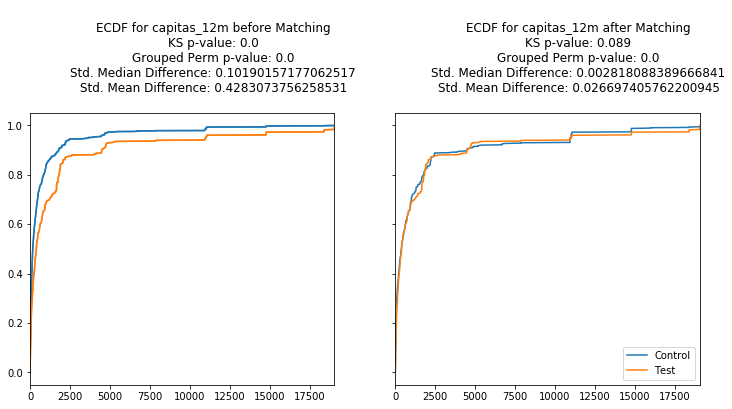

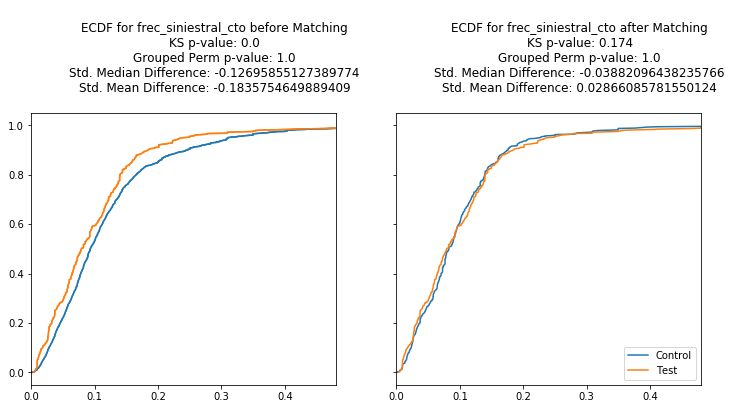

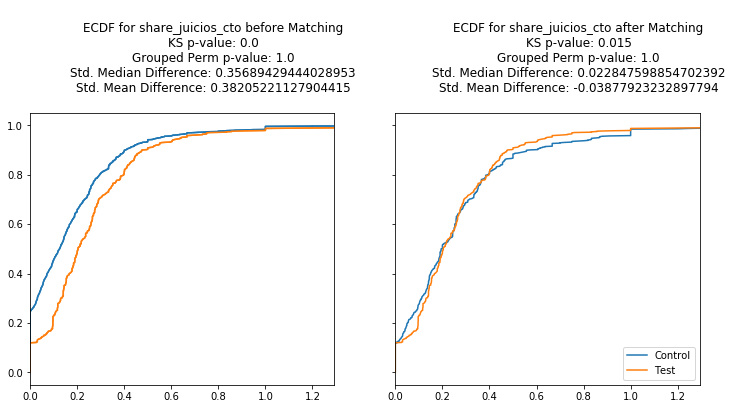

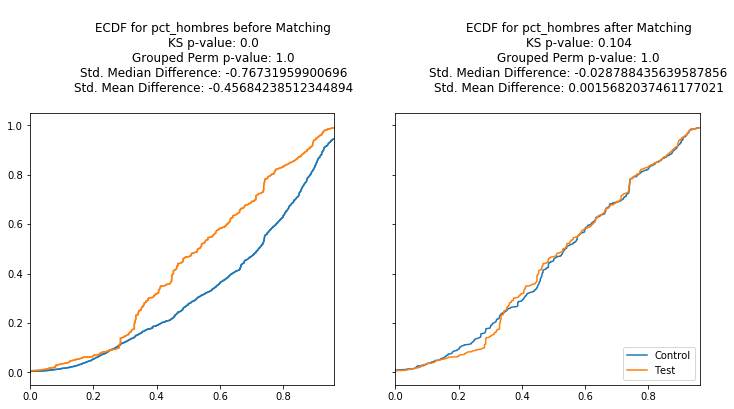

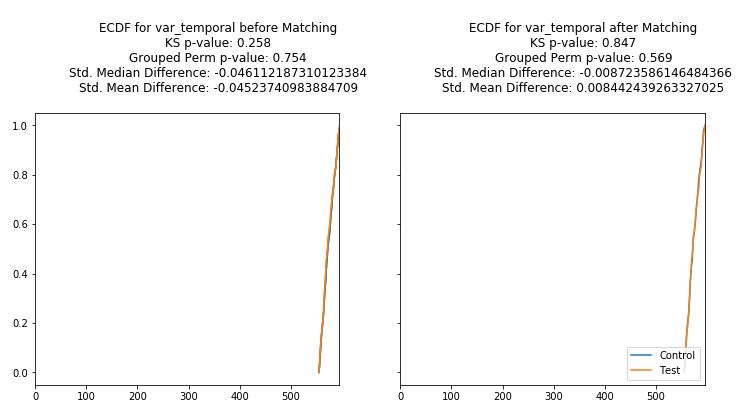

In [19]:
continuous_results = m.compare_continuous(return_table=True)

In [20]:
continuous_results

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,edad,0.090,0.767,0.370,0.466,-0.171,-0.090,-0.081,-0.009
1,ibm,0.000,0.030,0.001,0.000,0.065,0.067,0.196,0.095
2,antiguedad,0.001,0.075,0.571,0.004,-0.095,-0.035,-0.124,-0.026
3,capitas_12m,0.000,0.089,0.000,0.000,0.102,0.003,0.428,0.027
4,frec_siniestral_cto,0.000,0.174,1.000,1.000,-0.127,-0.039,-0.184,0.029
5,share_juicios_cto,0.000,0.015,1.000,1.000,0.357,0.023,0.382,-0.039
6,pct_hombres,0.000,0.104,1.000,1.000,-0.767,-0.029,-0.457,0.002
7,var_temporal,0.258,0.847,0.754,0.569,-0.046,-0.009,-0.045,0.008


We want the pvalues from both the KS-test and the grouped permutation of the Chi-Square distance after matching to be > 0.05, and almost all of them are. We can verify by looking at how close the ECDFs are between test and control.

This is a sample of our matched data. Note there has been assigned a match_id to each record indicating our paired matches since we use nmatches=1. We can verify that matched records have scores within 0.0005 of each other.

In [22]:
m.matched_data.sort_values("match_id").head(6)

,record_id,weight,mes_renovacion,fecha_acc,mes_acc,sexo,edad,ibm,antiguedad,PCIA_TDOR,sector,ciiu3,ciiu6,tamano_empresa,capitas_12m,masa_salarial_12m,frec_siniestral_cto,share_juicios_cto,pct_sin_graves_cto,pct_hombres,var_temporal,T_C,target,scores,match_id
0,0,1.000,201607.000,2017-06-01,201706,M,31,41904.730,4315,1.000,SERVICIOS FINANCIEROS,820.000,820016.000,101_250,208.167,12143959.279,0.012,0.368,0.132,0.808,577.267,1,0,0.604,0
990,4452,1.000,201409.000,2015-08-10,201508,F,48,240.000,544,8.000,SERVICIOS SOCIALES Y PERSONALES,931.000,931012.000,51_100,58.000,1047841.105,0.017,0.000,0.000,0.180,555.233,0,0,0.604,0
1,1,1.000,201507.000,2016-06-19,201606,M,28,1095.100,18,1.000,TRANSPORTE,711.000,711314.000,1_10,4.000,69717.793,0.050,2.000,0.000,1.000,565.700,1,0,0.907,1
1301,8442,1.000,201606.000,2017-05-08,201705,F,20,6929.380,30,2.000,COMERCIO MAYORISTA Y MINORISTA,624.000,624403.000,1_10,7.500,131021.828,0.044,1.000,0.000,0.143,576.467,0,0,0.907,1
2,2,1.000,201507.000,2016-06-09,201606,F,54,26896.090,6491,1.000,SERVICIOS SOCIALES Y PERSONALES,935.000,935018.000,251-500,497.389,28425193.009,0.043,0.111,0.120,0.518,565.367,1,0,0.513,2
1176,7073,1.000,201612.000,2017-11-16,201711,M,49,16270.380,138,2.000,SERVICIOS FINANCIEROS,832.000,832952.000,101_250,153.917,4389035.578,0.052,0.375,0.104,0.799,582.867,0,0,0.513,2


To finally assess that the matching procedure has been correct, we perform again t-tests for all covariates to determine if overt biases has been eliminated.

In [24]:
print('t-test for edad: ', stats.ttest_ind(m.matched_data[m.matched_data['T_C'] == 1]['edad'], m.matched_data[m.matched_data['T_C'] == 0]['edad']))
print('t-test for ibm: ', stats.ttest_ind(m.matched_data[m.matched_data['T_C'] == 1]['ibm'], m.matched_data[m.matched_data['T_C'] == 0]['ibm']))
print('t-test for antiguedad: ', stats.ttest_ind(m.matched_data[m.matched_data['T_C'] == 1]['antiguedad'], m.matched_data[m.matched_data['T_C'] == 0]['antiguedad']))
print('t-test for capitas_12m: ', stats.ttest_ind(m.matched_data[m.matched_data['T_C'] == 1]['capitas_12m'], m.matched_data[m.matched_data['T_C'] == 0]['capitas_12m']))
print('t-test for frec_siniestral_cto: ', stats.ttest_ind(m.matched_data[m.matched_data['T_C'] == 1]['frec_siniestral_cto'], m.matched_data[m.matched_data['T_C'] == 0]['frec_siniestral_cto']))
print('t-test for share_juicios_cto: ', stats.ttest_ind(m.matched_data[m.matched_data['T_C'] == 1]['share_juicios_cto'], m.matched_data[m.matched_data['T_C'] == 0]['share_juicios_cto']))
print('t-test for pct_hombres: ', stats.ttest_ind(m.matched_data[m.matched_data['T_C'] == 1]['pct_hombres'], m.matched_data[m.matched_data['T_C'] == 0]['pct_hombres']))
print('t-test for var_temporal: ', stats.ttest_ind(m.matched_data[m.matched_data['T_C'] == 1]['var_temporal'], m.matched_data[m.matched_data['T_C'] == 0]['var_temporal']))

t-test for edad:  Ttest_indResult(statistic=-0.17630429309694265, pvalue=0.8600795771438332)
t-test for ibm:  Ttest_indResult(statistic=1.8001552713525109, pvalue=0.07204447444986639)
t-test for antiguedad:  Ttest_indResult(statistic=-0.48966660924582295, pvalue=0.624444108601126)
t-test for capitas_12m:  Ttest_indResult(statistic=0.5076470998781301, pvalue=0.6117782719884144)
t-test for frec_siniestral_cto:  Ttest_indResult(statistic=0.5449892472487208, pvalue=0.5858449557345498)
t-test for share_juicios_cto:  Ttest_indResult(statistic=-0.7374541293814943, pvalue=0.46096587394201605)
t-test for pct_hombres:  Ttest_indResult(statistic=0.029816507462098317, pvalue=0.9762175081329838)
t-test for var_temporal:  Ttest_indResult(statistic=0.1605188224169017, pvalue=0.8724948166164936)


 All p-values are greater than 0.05, indicating that the matching procedure was successful.

## Difference-in-Difference

In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

Having matched the treatment and control groups, we are now able to apply the diff-in-diff technique in order to determine if the implementation of the new law have had a real effect on judiciality. This technique consists on performing a regression including a time variable, the treatment/control variable, its interaction and different control variables.

**y = B0 + B1 x Time + B2 x GroupID + B3 x TimeGroupID + Bn x Controln + error**

In [23]:
formu = " target ~ var_temporal * C(T_C, Treatment(0)) + " + \
        " C(sexo,Treatment('M')) +" +\
        " edad + ibm + antiguedad +" +\
        " C(tamano_empresa,Treatment('1_10')) +frec_siniestral_cto + share_juicios_cto+ pct_hombres +" +\
        " C(sector,Treatment('SERVICIOS SOCIALES Y PERSONALES'))"

m.matched_data = sm.add_constant(m.matched_data)
offsetTrain = np.log(m.matched_data['capitas_12m'])

freqModel = smf.glm(formula=formu,
                    data=m.matched_data,
                    family=sm.families.Poisson(sm.genmod.families.links.log),
                    offset=offsetTrain).fit()

freqModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                 1448
Model:                            GLM   Df Residuals:                     1425
Model Family:                 Poisson   Df Model:                           22
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -539.14
Date:                Thu, 03 Oct 2019   Deviance:                       704.28
Time:                        19:53:38   Pearson chi2:                 1.55e+03
No. Iterations:                    19   Covariance Type:             nonrobust
=============================================================================================================================================================
                                                                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                     9.2614      5.967      1.552      0.121      -2.434      20.957
C(T_C, Treatment(0))[T.1]                                                                    28.5772      8.780      3.255      0.001      11.368      45.786
C(sexo, Treatment('M'))[T.F]                                                                  0.0346      0.187      0.185      0.853      -0.333       0.402
C(tamano_empresa, Treatment('1_10'))[T.101_250]                                              -2.4297      0.519     -4.679      0.000      -3.447      -1.412
C(tamano_empresa, Treatment('1_10'))[T.10_25]                                                 0.0452      0.529      0.085      0.932      -0.992       1.082
C(tamano_empresa, Treatment('1_10'))[T.251-500]                                              -3.7535      0.549     -6.837      0.000      -4.830      -2.677
C(tamano_empresa, Treatment('1_10'))[T.26_50]                                                -1.0074      0.542     -1.860      0.063      -2.069       0.054
C(tamano_empresa, Treatment('1_10'))[T.51_100]                                               -1.6165      0.534     -3.028      0.002      -2.663      -0.570
C(tamano_empresa, Treatment('1_10'))[T.mas500]                                               -5.4551      0.524    -10.412      0.000      -6.482      -4.428
C(sector, Treatment('SERVICIOS SOCIALES Y PERSONALES'))[T.COMERCIO MAYORISTA Y MINORISTA]    -0.1175      0.236     -0.498      0.618      -0.580       0.345
C(sector, Treatment('SERVICIOS SOCIALES Y PERSONALES'))[T.CONSTRUCCION]                      -0.6944      0.794     -0.875      0.382      -2.250       0.861
C(sector, Treatment('SERVICIOS SOCIALES Y PERSONALES'))[T.ELECTRICIDAD, GAS Y AGUA]         -18.4144   1.44e+04     -0.001      0.999   -2.82e+04    2.82e+04
C(sector, Treatment('SERVICIOS SOCIALES Y PERSONALES'))[T.INDUSTRIA DE MANUFACTURA]           0.1428      0.253      0.563      0.573      -0.354       0.640
C(sector, Treatment('SERVICIOS SOCIALES Y PERSONALES'))[T.SERVICIOS FINANCIEROS]              0.2797      0.256      1.094      0.274      -0.221       0.781
C(sector, Treatment('SERVICIOS SOCIALES Y PERSONALES'))[T.TRANSPORTE]                        -0.8355      0.301     -2.780      0.005      -1.425      -0.246
var_temporal                                                                                 -0.0259      0.010     -2.498      0.012      -0.046      -0.006
var_temporal:C(T_C, Treatment(0))[T.1]                                                       -0.0508      0.015     -3.281      0.001      -0.081      -0.020
ed

It can be seen that the three variables are statistically significant (p-value < 0.05). The three most relevant coefficients for the diff-in-diff technique are the ones associated with *Time*, *GroupID* and its *interaction effect*.

**var_temporal** (*Time*)
- Coefficient: -0.0259
- P-Value: 0.012

**C(T_C, Treatment(0))[T.1]** (*GroupID*)
- Coefficient: 28.5772
- P-Value: 0.001

**var_temporal:C(T_C, Treatment(0))[T.1]** (*Time * GroupID*)
- Coefficient: -0.0508
- P-Value: 0.001

The real effect caused by the treatment is represented by the coefficient of *var_temporal:C(T_C, Treatment(0))[T.1]*. 

In conclusion, we have proved that **there is a statistically significant reduction in judiciality because of the implementation of the new law in the labor risk market, and that this shrinkage is of e(-0.0508)=0.95 with respect to the control group (no implemented law), namely a 5% reduction**.
